In [91]:
import torch
import torch.nn as nn

In [92]:
#W8A16 Linear Layer

def linear_quantize(tensor, dtype=torch.int8):
    r_min = tensor.min().item()
    r_max = tensor.max().item()
    # print(r_min, r_max)
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    
    if r_max - r_min <= 1e-5:
        scale = 2 * r_max / (q_max - q_min)
        zero_point = torch.tensor(0, device=tensor.device)
    
    else:
        
        scale = (r_max - r_min) / (q_max - q_min)
        # print(scale)
        zero_point = torch.round(torch.tensor(q_min - (r_min / scale), device=tensor.device)).to(torch.int8).item()

        zero_point = torch.clamp_(torch.tensor(zero_point, device=tensor.device), min=q_min, max=q_max)
        
    quantized_tensor = torch.round(tensor / scale + zero_point)
    quantized_tensor = torch.clamp_(quantized_tensor, min=q_min, max=q_max).to(torch.int8)
    return scale, zero_point.item(), quantized_tensor

def channel_linear_quantize(tensor, dim=0, dtype=torch.int8):
    device = tensor.device
    scales = torch.zeros(tensor.size(dim), device=device)
    zero_pts = torch.zeros(tensor.size(dim), dtype=torch.int8, device=device)

    quantized_tensor = torch.zeros_like(tensor, dtype=dtype)

    for i in range(tensor.size(dim)):
        scales[i], zero_pts[i], quant = linear_quantize(tensor.select(dim, i), dtype=dtype)

        if dim == 1:
            quantized_tensor[:, i] = quant
        else:
            quantized_tensor[i, :] = quant
            
    if (dim == 0):
        scales = scales.view(scales.shape[dim], -1)
        zero_pts = zero_pts.view(zero_pts.shape[dim], -1)
    elif dim == 1:
        
        scales = scales.view(-1, scales.shape[0])
        zero_pts = zero_pts.view(-1, zero_pts.shape[0])
        
    # quantized_tensor = torch.clamp_(torch.round(tensor / scales + zero_pts), 
    #                                   min=torch.iinfo(dtype).min, 
    #                                   max=torch.iinfo(dtype).max).to(torch.int)
    return scales, zero_pts, quantized_tensor

In [93]:
torch.randn(3,1)

tensor([[-0.2834],
        [-0.0146],
        [-1.2557]])

In [94]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features=4, out_features=16, dtype=torch.float32, bias=None):
        super(W8A16LinearLayer, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.register_buffer('int8_weights', torch.randint(torch.iinfo(torch.int8).min, torch.iinfo(torch.int8).max, (out_features, in_features), dtype=torch.int8, device=device))
        self.register_buffer('scales', torch.randn(out_features, 1, dtype=dtype, device=device))
        self.register_buffer('zero_point', torch.randint(torch.iinfo(torch.int8).min, torch.iinfo(torch.int8).max, (out_features, 1), dtype=torch.int8, device=device))
        self.dtype = dtype
        
        # Handle bias properly - bias parameter is the actual bias tensor or None
        if bias is not None:
            self.register_buffer('bias', bias.clone().to(device))
        else:
            self.bias = None

    def quantize(self, x):
        
        device = self.int8_weights.device
        x = x.to(device).to(torch.float32)
        scales, zero_pts, quant_weights = channel_linear_quantize(x, dim=0)
        # print(scales)
        #    Use .copy_() for an in-place update.
        # print(scales.shape)
        # print(zero_pts.shape)
        # print(self.scales.shape)
        # print(self.zero_point.shape)
        # print(self.int8_weights.shape)
        self.int8_weights.copy_(quant_weights.to(device))
        self.scales.copy_(scales.to(device)) 
        self.zero_point.copy_(zero_pts.to(device))
        return scales, zero_pts, quant_weights
    
    def linear_dequantize(self, scales, zero_pts, quant):
        # Ensure all tensors are on the same device
        device = self.int8_weights.device
        scales = scales.to(device)
        zero_pts = zero_pts.to(device)
        quant = quant.to(device)
        return scales * (quant.float() - zero_pts.float())

    def forward(self, x, dtype=torch.bfloat16):
        device = self.int8_weights.device
        x = x.to(device)
        dequant = self.linear_dequantize(self.scales, self.zero_point, self.int8_weights)
        out = torch.matmul(x.to(dtype), dequant.T.to(dtype))
        
        # Add bias if it exists
        if self.bias is not None:
            out = out + self.bias.to(dtype)
            
        return out

In [95]:
def linear_dequantize(scale, zero_point, quantized_tensor):
    return scale * (quantized_tensor.float() - zero_point)


In [96]:
# Corrected test code
quantized_ly = W8A16LinearLayer()

# Store original weights before quantization
original_weights = quantized_ly.int8_weights.clone()
# print(original_weights.dtype)

# Quantize the weights
scales, zero_pts, quant = quantized_ly.quantize(original_weights)

# Dequantize to check reconstruction quality
dequantized_weights = quantized_ly.linear_dequantize(scales, zero_pts, quant)

# Calculate MSE between original and reconstructed weights
weight_mse = (dequantized_weights - original_weights.float()).pow(2).mean()
print(f"Weight reconstruction MSE: {weight_mse}")

# For forward pass comparison
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_input = torch.randn(1, 4, dtype=torch.bfloat16, device=device)  # Batch size 1
test_linear = nn.Linear(4, 16, bias=False, dtype=torch.bfloat16, device=device)
test_linear_out = test_linear(test_input)

print("Hhehehe")
original_weights_float = test_linear.weight.data
scales, zero_pts, quant = quantized_ly.quantize(original_weights_float)
dequantized_weights = quantized_ly.linear_dequantize(scales, zero_pts, quant)
test_linear.weight.data = dequantized_weights.to(torch.bfloat16).to(device)
test_out_dequan = test_linear(test_input)
out = quantized_ly.forward(test_input, dtype=torch.bfloat16)
# print(out)
print((test_out_dequan - test_linear_out).square().mean())  # Should be close to zero if weights are well reconstructed

Weight reconstruction MSE: 298.4534912109375
Hhehehe
tensor(0.0034, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)


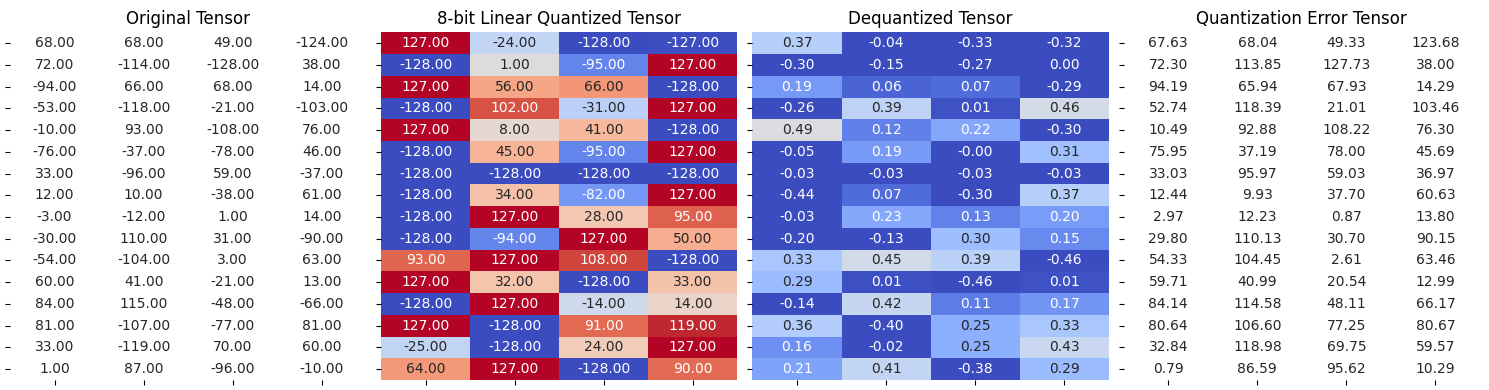

In [65]:
from helper import plot_quantization_errors

plot_quantization_errors(original_weights, quant, dequantized_weights)

In [97]:
def replace_linear_with_target_and_quantize(module, 
                               target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and not \
        any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias
            old_weight = child.weight.to('cuda' if torch.cuda.is_available() else 'cpu')

            # Pass the actual bias tensor (not just a boolean)
            new_module = target_class(child.in_features, 
                                      child.out_features, 
                                      child.weight.dtype, 
                                      bias=old_bias)  # Pass actual bias tensor
            
            # Move the new module to the same device as the original
            new_module = new_module.to(child.weight.device)
            setattr(module, name, new_module)

            # Quantize the weights
            getattr(module, name).quantize(old_weight)
            
        else:
            # Recursively call the function for nested modules
            replace_linear_with_target_and_quantize(child, 
                     target_class, module_name_to_exclude)

In [98]:
class DummyModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = torch.nn.Embedding(1, 1)
    # Try with bias
    self.linear_1 = nn.Linear(1, 1)
    # Try without bias
    self.linear_2 = nn.Linear(1, 1, bias=False)
    # Lm prediction head
    self.lm_head = nn.Linear(1, 1, bias=False)

In [99]:
model = DummyModel()
replace_linear_with_target_and_quantize(model, W8A16LinearLayer, [""])
print(model)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): W8A16LinearLayer()
)


In [100]:
# Test to show bias handling works correctly
print("=== Testing Bias Handling ===")

# Create a simple linear layer with bias
original_layer = nn.Linear(3, 2, bias=True)
print(f"Original layer bias: {original_layer.bias}")
print(f"Original layer bias shape: {original_layer.bias.shape}")
print(f"Original layer bias values: {original_layer.bias.data}")

# Replace with quantized version
quantized_layer = W8A16LinearLayer(3, 2, bias=original_layer.bias)
print(f"\nQuantized layer bias: {quantized_layer.bias}")
print(f"Quantized layer bias shape: {quantized_layer.bias.shape}")
print(f"Quantized layer bias values: {quantized_layer.bias}")

# Test forward pass
test_input = torch.randn(1, 3)
original_output = original_layer(test_input)
quantized_output = quantized_layer.forward(test_input, dtype=torch.float32)

print(f"\nOriginal output: {original_output}")
print(f"Quantized output: {quantized_output}")

# Check if bias values are preserved
bias_match = torch.allclose(original_layer.bias, quantized_layer.bias, atol=1e-6)
print(f"\nBias values match: {bias_match}")

=== Testing Bias Handling ===
Original layer bias: Parameter containing:
tensor([-0.1499,  0.5612], requires_grad=True)
Original layer bias shape: torch.Size([2])
Original layer bias values: tensor([-0.1499,  0.5612])

Quantized layer bias: tensor([-0.1499,  0.5612], device='cuda:0', grad_fn=<ToCopyBackward0>)
Quantized layer bias shape: torch.Size([2])
Quantized layer bias values: tensor([-0.1499,  0.5612], device='cuda:0', grad_fn=<ToCopyBackward0>)

Original output: tensor([[-0.9205,  1.0581]], grad_fn=<AddmmBackward0>)
Quantized output: tensor([[375.8679,  -4.4618]], device='cuda:0', grad_fn=<AddBackward0>)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [101]:
#Real Models nowwww

In [114]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "Salesforce/codegen-350M-mono"

model = AutoModelForCausalLM.from_pretrained(model_id, 
                                    torch_dtype=torch.bfloat16, 
                                             low_cpu_mem_usage=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

In [115]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [116]:
print(pipe("def hello_world():", max_new_tokens=20, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'def hello_world():\n    print("Hello World")\n\nhello_world()\n\n# 파'}]


In [117]:
print("Model before:\n\n", model)
# Move model to CUDA if available
if torch.cuda.is_available():
    model = model.to('cuda')
    print("Model moved to CUDA")

Model before:

 CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bi

In [118]:
replace_linear_with_target_and_quantize(model, W8A16LinearLayer, ["lm_head"])

In [119]:
model

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)

In [120]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
print(pipe("def hello_world():", max_new_tokens=20, do_sample=False))

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'def hello_world():\n    print("Hello World")\n\nhello_world()\n\n# 파'}]


In [121]:
quantized_state_dict = model.state_dict()
torch.save(quantized_state_dict, "quantized_state_dict.pth")

In [ ]:
from huggingface_hub import HfApi, create_repo

YOUR_HF_USERNAME = ""
your_repo_id = f"{YOUR_HF_USERNAME}/opt-125m-quantized-dlai"

api = HfApi()

# create_repo(your_repo_id)

api.upload_file(
 path_or_fileobj="quantized_state_dict.pth",
 path_in_repo="quantized_state_dict.pth",
 repo_id=your_repo_id
)

In [ ]:
from transformers import OPTForCausalLM, AutoTokenizer, AutoConfig

model_id = "facebook/opt-125m"
config = AutoConfig.from_pretrained(model_id)

with torch.device("meta"):
  model = OPTForCausalLM(config)

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
replace_linear_with_target(model, W8A16LinearLayer, ["lm_head"])

In [ ]:
from huggingface_hub import hf_hub_download

state_dict_cache_path = hf_hub_download(
    "ybelkada/opt-125m-quantized-dlai",
    "quantized_state_dict.pth"
)